In [14]:
import pickle
import numpy as np
import sys
sys.path.insert(0, '/home/abrahamn/21cmIRxcor/')
import cat_utils

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

from astropy.io.votable import parse
from astropy.table import Table

In [15]:
catdir = '/home/abrahamn/xcor_data/ir_catalogs/'
secat = pickle.load( open(catdir+'whole_field_secat.p', "rb" ) )
g = secat.jy>1.e-10
secat = cat_utils.Catalog(secat.ra[g],secat.dec[g],secat.jy[g])

In [16]:
# dophot cat
dophot_cat = cat_utils.IRCatalog('/home/abrahamn/xcor_data/ATLAS_mwa57694_rereduction/02a57694o0281I.dph')
dophot_cat.ra = dophot_cat.ra_all
dophot_cat.dec = dophot_cat.dec_all
dophot_cat.jy = dophot_cat.jy_all

loading /home/abrahamn/xcor_data/ATLAS_mwa57694_rereduction/02a57694o0281I.dph


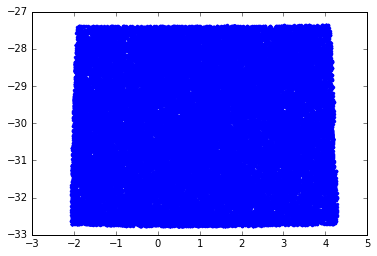

In [17]:
plt.plot(dophot_cat.ra_all,dophot_cat.dec_all,'.')

In [18]:
# to get early skymapper data, do a cone search through an australian proxy
# http://skymapper.anu.edu.au.prx.teleport.to/edr_cone/query?RA=1&DEC=-29&SR=.35&VERB=2

# need to edit the xml file and change datatypes "character(18)" and "character(3)" to "char"
skymappercat = parse(catdir + 'view-source_skymapper.anu.edu.au.prx.teleport.to_edr_cone_query_RA=1&DEC=-29&SR=.35&VERB=2.xml').get_first_table().array

In [19]:
skymappercat.dtype

dtype((numpy.record, [('r_cntr', '<f8'), ('smss_j', 'S1'), ('raj2000', '<f8'), ('dej2000', '<f8'), ('e_raj2000', '<i4'), ('e_dej2000', '<i4'), ('mean_epoch', '<f8'), ('rms_epoch', '<f4'), ('glon', '<f4'), ('glat', '<f4'), ('flags', '<i2'), ('class_star', '<f4'), ('nobs', 'S'), ('object_id', '<i8'), ('radius_petro', '<f4'), ('a', '<f4'), ('e_a', '<f4'), ('b', '<f4'), ('e_b', '<f4'), ('pa', '<f4'), ('e_pa', '<f4'), ('u_psf', '<f4'), ('e_u_psf', '<f4'), ('u_petro', '<f4'), ('e_u_petro', '<f4'), ('v_psf', '<f4'), ('e_v_psf', '<f4'), ('v_petro', '<f4'), ('e_v_petro', '<f4'), ('g_psf', '<f4'), ('e_g_psf', '<f4'), ('g_petro', '<f4'), ('e_g_petro', '<f4'), ('r_psf', '<f4'), ('e_r_psf', '<f4'), ('r_petro', '<f4'), ('e_r_petro', '<f4'), ('i_psf', '<f4'), ('e_i_psf', '<f4'), ('i_petro', '<f4'), ('e_i_petro', '<f4'), ('z_psf', '<f4'), ('e_z_psf', '<f4'), ('z_petro', '<f4'), ('e_z_petro', '<f4'), ('ebmv_sfd', '<f4'), ('prox', '<f4'), ('prox_id', '<i8'), ('density', '<i4'), ('twomass_key1', '<i8'), 

In [20]:
# http://skymapper.anu.edu.au/table-browser/
ra = skymappercat['raj2000']
dec = skymappercat['dej2000']
flags = skymappercat['flags']
ab_mag_psf = skymappercat['i_psf'] # mag measured by psf fitting
ab_mag_petro = skymappercat['i_petro'] # mag measured in an azimuthally averaged radius, see http://www.sdss.org/dr12/algorithms/magnitudes/#mag_petro

jy_psf = 3631.*10.**(-ab_mag_psf/2.5)
jy_petro = 3631.*10.**(-ab_mag_petro/2.5)

In [21]:
secat_bounded = secat.limit_to_ra_dec_min_max(np.min(ra),np.max(ra),np.min(dec),np.max(dec))
dophot_cat_bounded = dophot_cat.limit_to_ra_dec_min_max(np.min(ra),np.max(ra),np.min(dec),np.max(dec))

secat_bounded_ab_mag = -2.5*np.log10(secat_bounded.jy/3631.)
dophot_cat_bounded_ab_mag = -2.5*np.log10(dophot_cat_bounded.jy/3631.)

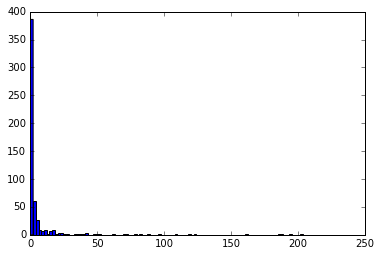

In [22]:
a = plt.hist(secat_bounded.jy*1000,100)

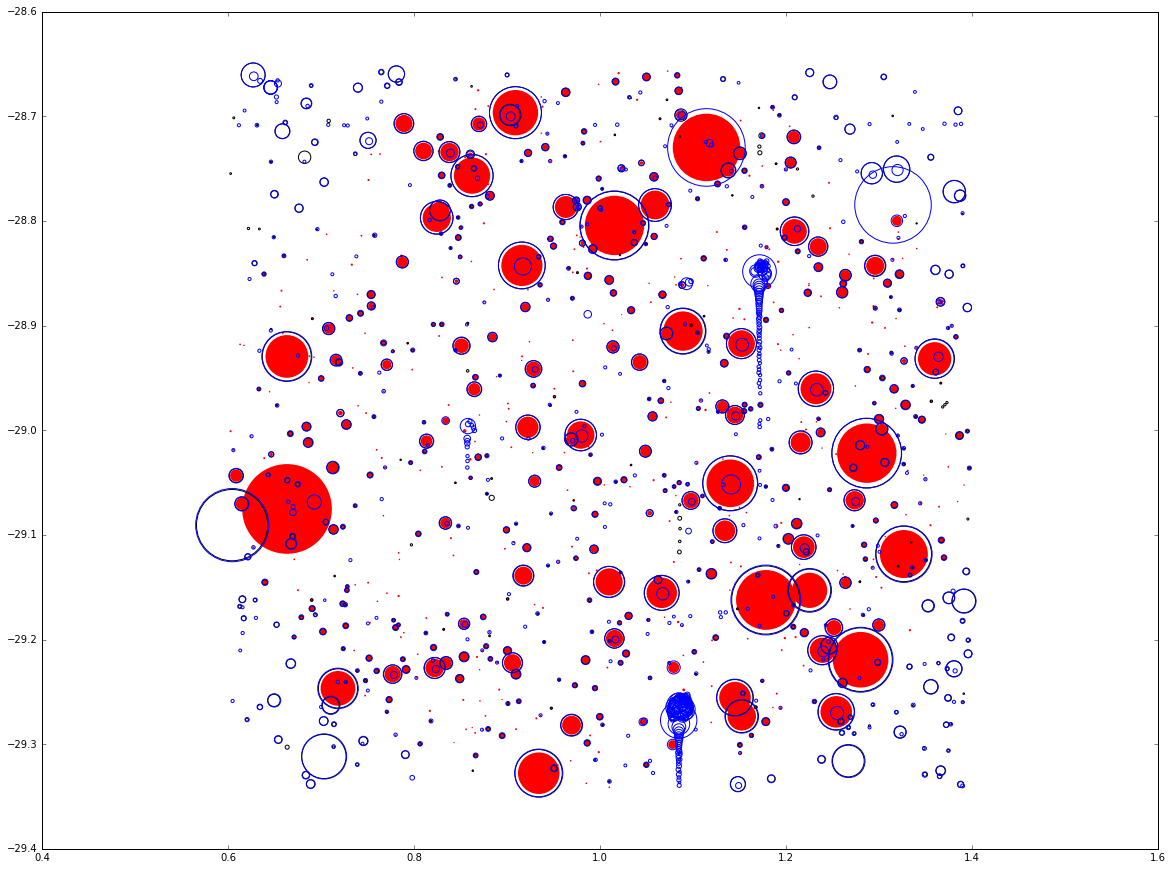

In [23]:
plt.figure(figsize=(20,15))
plt.scatter(ra,dec,25000*jy_psf,edgecolor='none',facecolor='red')

plt.scatter(secat_bounded.ra,secat_bounded.dec,25000*secat_bounded.jy,facecolor='none')
plt.scatter(dophot_cat_bounded.ra,dophot_cat_bounded.dec,25000*dophot_cat_bounded.jy,facecolor='none',edgecolor='blue')

In [24]:
# for each skymapper source, look for a matching skymapper source

indices_of_matching_sex_sources = np.zeros(len(jy_psf),dtype=int)-1 # -1 if no match
indices_of_matching_dophot_sources = np.zeros(len(jy_psf),dtype=int)-1 # -1 if no match
for i in range(len(jy_psf)):
    asec_to_all_sex_sources = np.sqrt((dec[i]-secat_bounded.dec)**2+np.sin(dec[i]*np.pi/180)**2*(ra[i]-secat_bounded.ra)**2)*3600.
    if np.min(asec_to_all_sex_sources) < 1:
        indices_of_matching_sex_sources[i] = np.argmin(asec_to_all_sex_sources)
        
    asec_to_all_dophot_sources = np.sqrt((dec[i]-dophot_cat_bounded.dec)**2+np.sin(dec[i]*np.pi/180)**2*(ra[i]-dophot_cat_bounded.ra)**2)*3600.
    if np.min(asec_to_all_dophot_sources) < 1:
        indices_of_matching_dophot_sources[i] = np.argmin(asec_to_all_dophot_sources)

In [25]:
# plt.figure(figsize=(6,6))

# #plt.plot(secat_bounded_ab_mag[indices_of_matching_skymapper_sources>0],ab_mag_psf[indices_of_matching_skymapper_sources[indices_of_matching_skymapper_sources>0]],'r.')
# plt.plot(secat_bounded_ab_mag[indices_of_matching_skymapper_sources>0],ab_mag_petro[indices_of_matching_skymapper_sources[indices_of_matching_skymapper_sources>0]],'b.')

# # plt.plot(np.array([10,20]),np.array([10,20]),'k-')
# # plt.plot(np.array([10,20]),np.array([10,20])+.5,'k--')

# plt.xlim([10,20])
# plt.ylim([10,20])
# plt.axes().set_aspect('equal')
# plt.xlabel('ATLAS/SExtractor (AB mag)')
# plt.ylabel('SkyMapper i band (AB mag)')

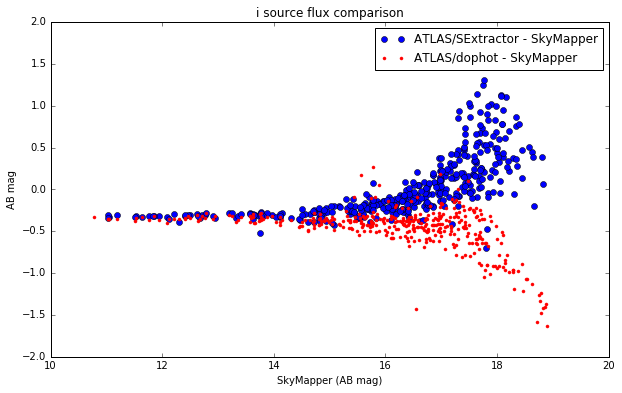

In [26]:
plt.figure(figsize=(10,6))

plt.plot(ab_mag_petro[indices_of_matching_sex_sources>0],\
         secat_bounded_ab_mag[indices_of_matching_sex_sources[indices_of_matching_sex_sources>0]]-ab_mag_petro[indices_of_matching_sex_sources>0],'bo',\
         label='ATLAS/SExtractor - SkyMapper')

plt.plot(ab_mag_petro[indices_of_matching_dophot_sources>0],\
         dophot_cat_bounded_ab_mag[indices_of_matching_dophot_sources[indices_of_matching_dophot_sources>0]]-ab_mag_petro[indices_of_matching_dophot_sources>0],'r.',\
         label='ATLAS/dophot - SkyMapper')

plt.xlim([10,20])
# plt.ylim([10,20])
plt.ylabel('AB mag')
plt.legend()
plt.ylim([-2,2])
plt.xlabel('SkyMapper (AB mag)')
plt.title('i source flux comparison')